In [ ]:
# ------------------------------
# 1. Importation des bibliothèques
# ------------------------------

# Traitement des données
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from graphviz import Digraph

# Prétraitement des données
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

# Deep Learning (TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Importation des données et premières visualisations

In [128]:
# Charger les données
port_calls = pd.read_csv("/content/port_calls.csv")
trades = pd.read_csv("/content/trades.csv")
vessels = pd.read_csv("/content/vessels.csv")

# Supprimer les lignes contenant des valeurs NaN
trades.dropna(inplace=True)
port_calls.dropna(inplace=True)
vessels.dropna(inplace=True)

# Exploration des données
print("Port Calls Info:")
print(port_calls.info())
print("\nTrades Info:")
print(trades.info())
print("\nVessels Info:")
print(vessels.info())

Port Calls Info:
<class 'pandas.core.frame.DataFrame'>
Index: 297134 entries, 0 to 347276
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     297134 non-null  int64  
 1   vessel_id              297134 non-null  int64  
 2   start_utc              297134 non-null  object 
 3   end_utc                297134 non-null  object 
 4   cargo_volume           297134 non-null  int64  
 5   draught_change         297134 non-null  float64
 6   destination            297134 non-null  object 
 7   destination_longitude  297134 non-null  float64
 8   destination_latitude   297134 non-null  float64
dtypes: float64(3), int64(3), object(3)
memory usage: 22.7+ MB
None

Trades Info:
<class 'pandas.core.frame.DataFrame'>
Index: 236926 entries, 0 to 240036
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   ----

### Summary of Key Information in the `port_calls` Dataset:

- **`id`**: Unique identifier for the port call record.
- **`vessel_id`**: Unique identifier for the vessel.
- **`start_utc`**: Start date and time of the port call.
- **`end_utc`**: End date and time of the port call.
- **`cargo_volume`**: Volume of cargo transported during the port call.
- **`draught_change`**: Change in the vessel's draft during the port call.
- **`destination`**: Name of the destination (port/city).
- **`destination_longitude`**: Longitude of the destination.
- **`destination_latitude`**: Latitude of the destination.

### Summary of Key Information in the `vessels` Dataset:

- **`id`**: Unique identifier for the vessel.
- **`status`**: Current status of the vessel (e.g., "Active" indicates the vessel is in service).
- **`status_detail`**: Additional details about the vessel's status (e.g., "In Service/Commission" indicates the vessel is operational or in commission).
- **`build_country`**: Country where the vessel was built.
- **`build_year`**: Year of the vessel's construction.
- **`flag_name`**: Country under which the vessel is registered.
- **`dead_weight`**: Gross weight of the vessel (in tons), i.e., the maximum cargo weight it can carry.
- **`vessel_type`**: Type of the vessel (e.g., "Crude/Oil Products Tanker" indicates it is a tanker for crude or refined products).

### Summary of Key Information in the `trades` Dataset:

- **`id`**: Unique identifier for the trade record.
- **`port_call_origin_id`**: Identifier for the port call of origin.
- **`port_call_destination_id`**: Identifier for the port call of destination.
- **`traded_volume`**: Volume of goods traded (often in tons or other appropriate units of measure).
- **`distance`**: Distance traveled for the trade, typically between the port of origin and the destination port, in kilometers or miles.
- **`start_date_time`**: Date and time when the trade or operation began.
- **`end_date_time`**: Date and time when the trade or operation ended.
- **`product`**: Type of product traded (e.g., oil, gas, containers, etc.).
- **`product_family`**: Category or group of the traded product (e.g., energy, raw materials, manufactured goods, etc.).
- **`duration`**: Total duration of the trade or operation, typically expressed in hours or days.

relation entre les bases

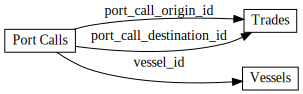

In [129]:
# Créer un graphe orienté avec une disposition horizontale
dot = Digraph(format='png', graph_attr={'rankdir': 'LR'})  # 'LR' pour horizontal

# Ajouter les tables sous forme de carrés (rectangles)
dot.node('PC', 'Port Calls', shape='rect', width='0.25', height='0.25')
dot.node('T', 'Trades', shape='rect', width='0.25', height='0.25')
dot.node('V', 'Vessels', shape='rect', width='0.25', height='0.25')

# Ajouter les relations entre les tables
dot.edge('PC', 'T', label='port_call_origin_id')
dot.edge('PC', 'T', label='port_call_destination_id')
dot.edge('PC', 'V', label='vessel_id')

# Visualiser le graphe
dot

## faire les jointures necessiares

### First Join:
The code cleans and restructures the *port_calls* DataFrame by performing several steps. We begin by renaming certain columns to make them more explicit, then remove unnecessary columns such as *destination_longitude* and *destination_latitude*. Next, we convert the *start_utc* and *end_utc* columns to datetime format to facilitate time-based calculations. We add a new column *duration(h)* to calculate the duration of the port calls in hours, based on the time difference between *start_utc* and *end_utc*. Afterward, we reorganize the columns to place *name* in the second position.

We proceed with a join with the *vessels* DataFrame to add additional information about the ships, such as the ship type and deadweight tonnage. Once the join is completed, we remove the *id* column from *vessels*, which becomes redundant. Finally, we rearrange the columns and adjust the names to improve the readability and clarity of our table, before renaming it to *port_name*. This process prepares the DataFrame for more in-depth analysis.

In [130]:
# Renommer les colonnes
port_calls.rename(columns={'destination': 'name', 'id': 'id_port_calls'}, inplace=True)

# Supprimer les colonnes 'destination_longitude' et 'destination_latitude'
port_calls.drop(columns=['destination_longitude', 'destination_latitude'], inplace=True)

# Convertir les colonnes 'start_utc' et 'end_utc' en datetime
port_calls['start_utc'] = pd.to_datetime(port_calls['start_utc'])
port_calls['end_utc'] = pd.to_datetime(port_calls['end_utc'])

# Calculer la durée entre 'end_utc' et 'start_utc' et stocker dans une nouvelle colonne 'duration'
port_calls['duration(h)'] = ((port_calls['end_utc'] - port_calls['start_utc']).dt.total_seconds() // 3600).astype(int)

# Réorganiser les colonnes pour que 'name' soit la 2ème colonne
port_calls = port_calls[['id_port_calls', 'name', 'vessel_id','duration(h)', 'cargo_volume', 'draught_change']]

# Effectuer la jointure pour ajouter 'vessel_type' et 'dead_weight' dans port_calls
port_calls = port_calls.merge(vessels[['id', 'vessel_type', 'dead_weight','status_detail']], left_on='vessel_id', right_on='id', how='left')

# Supprimer la colonne 'id' de vessels qui est maintenant en trop
port_calls.drop(columns=['id'], inplace=True)

port_calls = port_calls[['id_port_calls', 'name', 'vessel_id','vessel_type', 'dead_weight','status_detail','duration(h)', 'cargo_volume', 'draught_change']]
port_calls.rename(columns={'name': 'port_name'}, inplace=True)

# Afficher les premières lignes pour vérifier
port_calls

,id_port_calls,port_name,vessel_id,vessel_type,dead_weight,status_detail,duration(h),cargo_volume,draught_change
0,366999220,Novorossiysk,74064,Crude/Oil Products Tanker,103232.0,In Service/Commission,16,111617,5.5
1,366974831,Singapore,70585,Chemical/Oil Products Tanker,37620.0,In Service/Commission,15,0,-0.2
2,367187709,Philadelphia,90771,Crude/Oil Products Tanker,156657.0,In Service/Commission,47,0,-5.5
3,366902380,Sao Luis,86336,Crude Oil Tanker,50091.0,In Service/Commission,61,0,-4.7
4,366971646,Ulsan,105430,Chemical/Oil Products Tanker,13148.0,In Service/Commission,25,0,-2.0
...,...,...,...,...,...,...,...,...,...
297129,371284604,Mumbai,66035,Crude/Oil Products Tanker,10314.0,In Service/Commission,29,9298,2.5
297130,371322790,Ichthys Venturer,117014,Crude Oil Tanker,109999.0,In Service/Commission,65,90623,3.5
297131,371325317,Kerch Light.,114497,Products Tanker,7036.0,In Service/Commission,3,0,-1.3
297132,371325308,Kalamata Light.,73804,Crude/Oil Products Tanker,158609.0,In Service/Commission,104,0,-4.9


### Second Join:
We are preparing and enriching our `trades` dataset by structuring the data and integrating additional information. We begin by converting the dates and calculating the journey duration in hours (`duration_target(h)`). Then, we perform two joins with `port_calls` to retrieve details about the origin and destination ports of the trade transactions. Finally, we select the most relevant columns, remove rows with missing values, and save the final DataFrame as a CSV file, ready for further use.

In [131]:
# Convertir les colonnes 'start_date_time' et 'end_date_time' en datetime
trades['start_date_time'] = pd.to_datetime(trades['start_date_time'])
trades['end_date_time'] = pd.to_datetime(trades['end_date_time'])
trades.rename(columns={'id': 'trades_id'}, inplace=True)
trades['distance'] = trades['distance'].astype(int)
trades['duration_target(h)'] = ((trades['end_date_time'] - trades['start_date_time']).dt.total_seconds() // 3600).astype(int)
trades=trades[['trades_id', 'port_call_origin_id', 'port_call_destination_id','traded_volume','distance','duration_target(h)',"product","product_family"]]

# Joindre trades avec port_calls sur port_call_origin_id
trades_with_origin = trades.merge(port_calls[['id_port_calls', 'port_name','vessel_id','vessel_type','dead_weight','status_detail','duration(h)',
                                              'cargo_volume','draught_change']],
                                  left_on='port_call_origin_id',
                                  right_on='id_port_calls',
                                  how='left')

# Joindre trades_with_origin avec port_calls sur port_call_destination_id
trades_with_both_ports = trades_with_origin.merge(port_calls[['id_port_calls', 'port_name']],
                                                  left_on='port_call_destination_id',
                                                  right_on='id_port_calls',
                                                  how='left',
                                                  suffixes=('_origin', '_destination'))
trades_with_both_ports.rename(columns={'duration(h)': 'duration_stay_origin_port'}, inplace=True)

# Afficher les premières lignes pour vérifier
final=trades_with_both_ports[['trades_id','port_name_origin', 'port_name_destination','vessel_id','vessel_type','dead_weight','cargo_volume','duration_stay_origin_port','draught_change','traded_volume','distance','duration_target(h)',"product","product_family"]]
final.dropna(inplace=True)
final.to_csv("final.csv", index=False)

<ipython-input-131-b31ad00027e7>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final.dropna(inplace=True)


In [132]:
final.head()

,trades_id,port_name_origin,port_name_destination,vessel_id,vessel_type,dead_weight,cargo_volume,duration_stay_origin_port,draught_change,traded_volume,distance,duration_target(h),product,product_family
0,19953452,Jakarta,Singapore,115306.0,Chemical/Oil Products Tanker,8714.0,4981.0,14.0,1.0,260.0,1342175,163,palm fatty acid distillate,chem/bio
1,19322180,Jakarta,Kuantan,115306.0,Chemical/Oil Products Tanker,8714.0,4981.0,14.0,1.0,4551.0,1836735,200,palm fatty acid distillate,chem/bio
2,19953448,Jakarta,Port Klang,115306.0,Chemical/Oil Products Tanker,8714.0,4981.0,14.0,1.0,170.0,2714319,461,palm fatty acid distillate,chem/bio
3,19284088,Cilegon,Singapore,115306.0,Chemical/Oil Products Tanker,8714.0,6639.0,20.0,0.5,1658.0,1197777,85,used cooking oil,chem/bio
4,19339728,Port Dickson,Port Klang,115306.0,Chemical/Oil Products Tanker,8714.0,11404.0,34.0,2.0,11234.0,101991,53,chem/bio,chem/bio




---

### Visualization of Results:
Data visualization allows us to better understand the trends and relationships within our dataset. We used several charts to explore different aspects of maritime routes, ships, and the products transported. For example, we plotted the number of routes by destination and product to identify the most frequented areas and the most traded products.

We also explored the duration of the trips using a histogram and observed the relationship between cargo volume and draft change using a scatter plot. Furthermore, we studied the distribution of vessel types by destination and the distribution of ships by year of construction, type, and deadweight. These visualizations help us better interpret the data and extract valuable insights for our analysis.

<ipython-input-143-e59285ca49f5>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=destination_counts.index, y=destination_counts.values, palette="viridis")


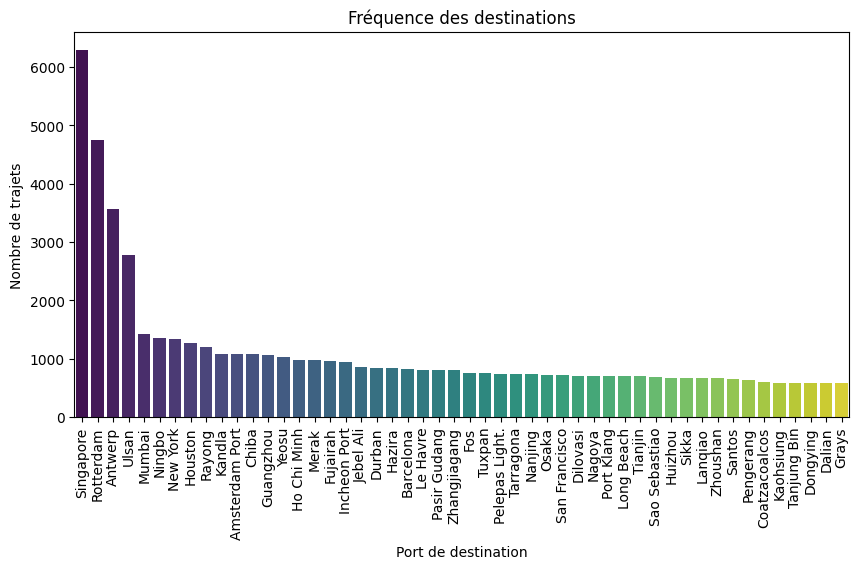

<ipython-input-143-e59285ca49f5>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=product_counts.index, y=product_counts.values, palette="magma")


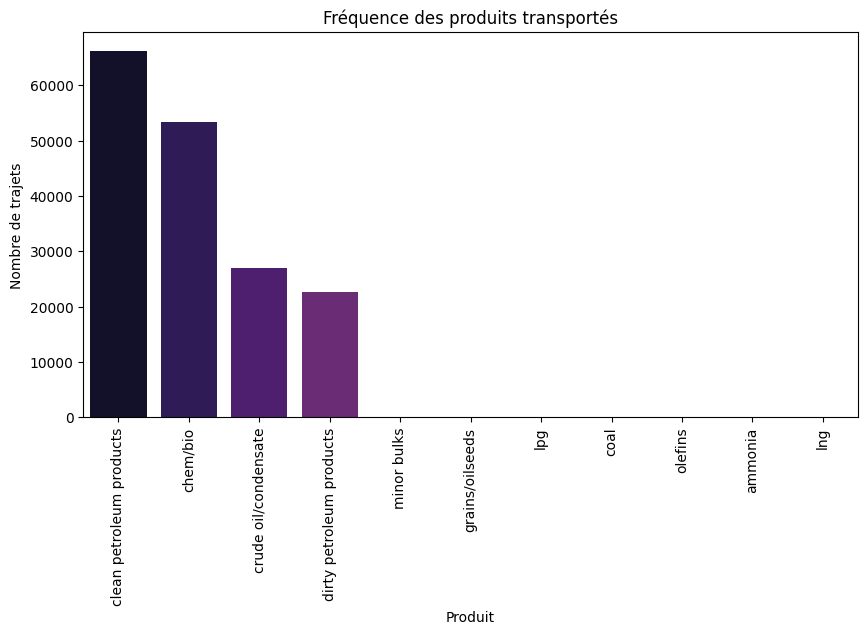

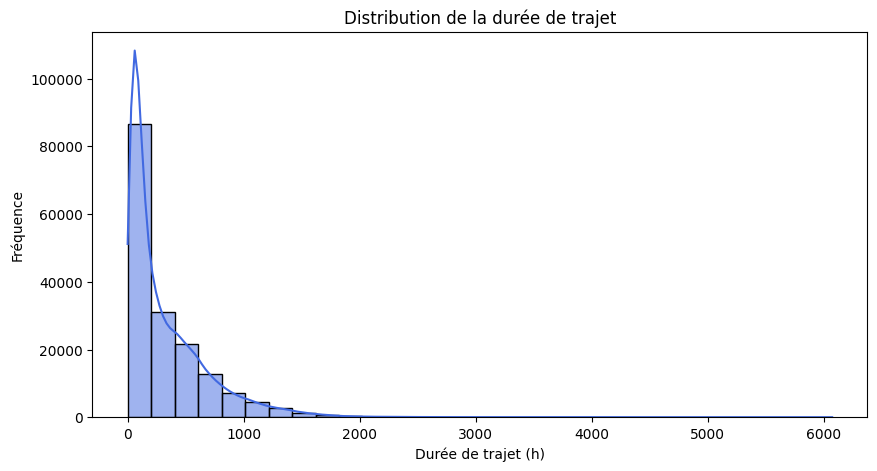

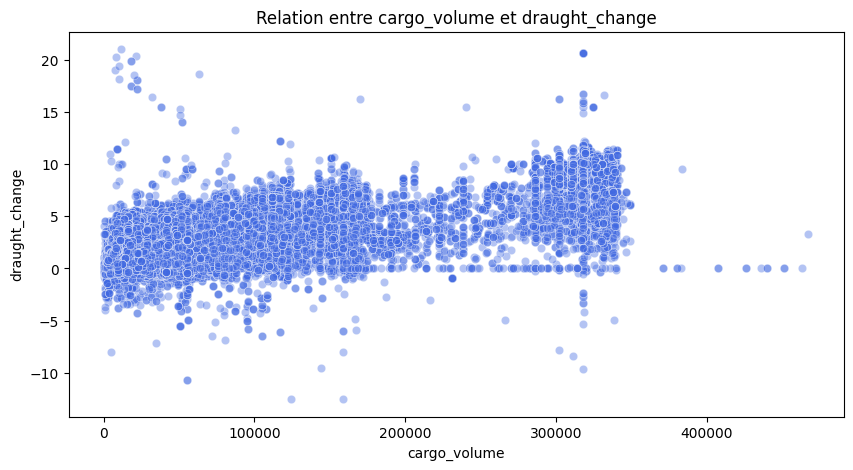

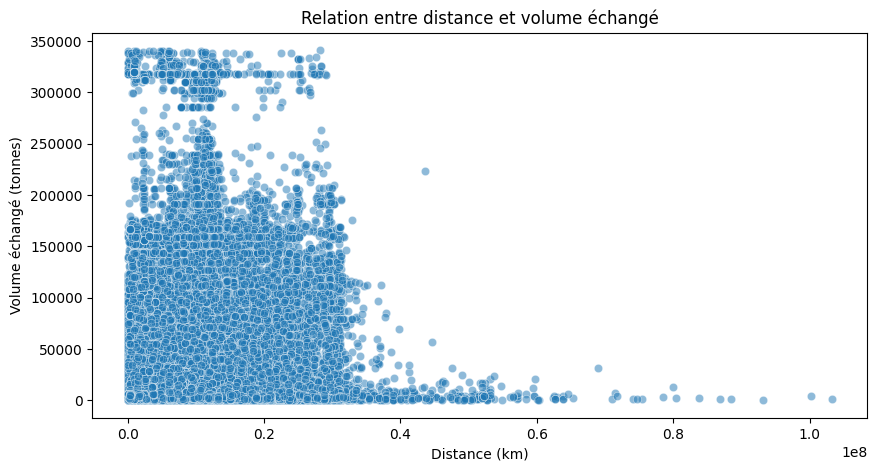

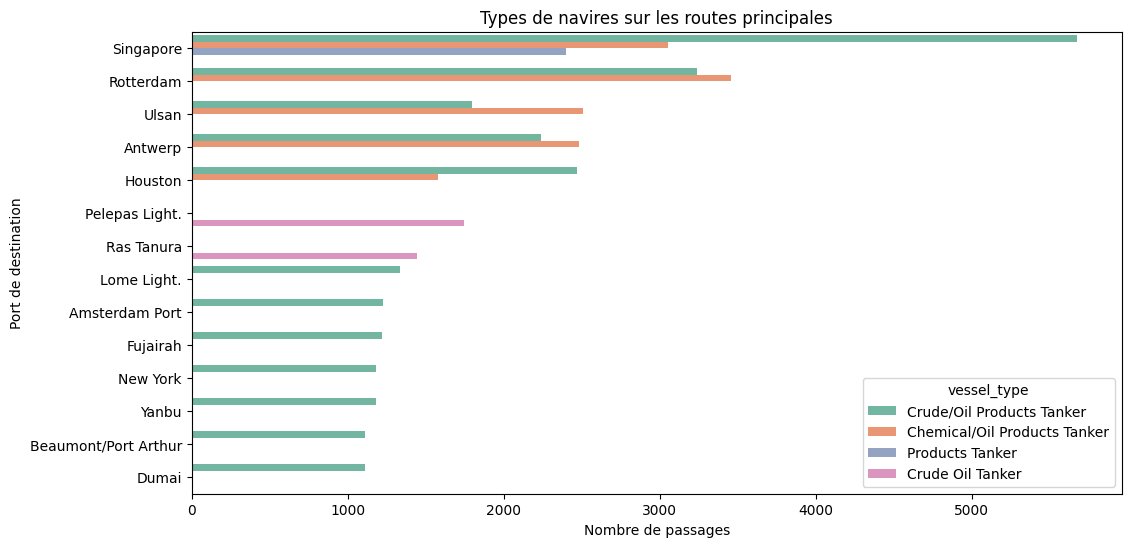

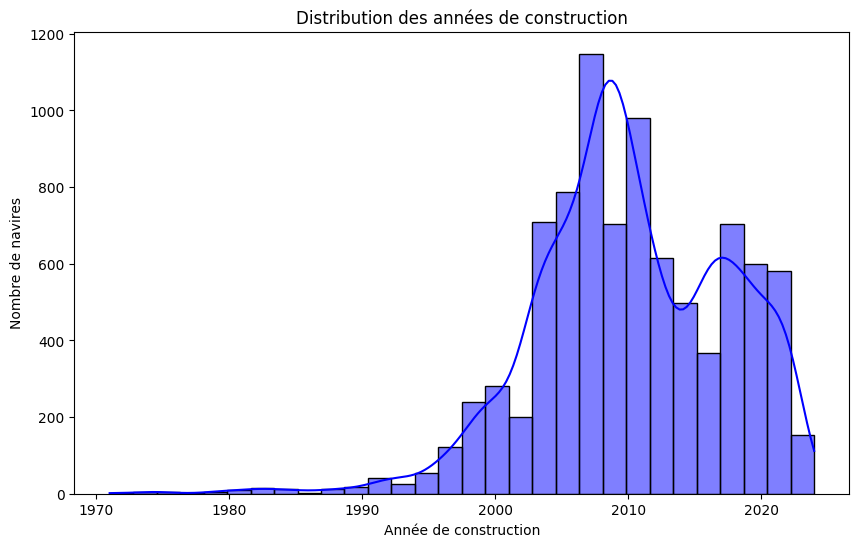

<ipython-input-143-e59285ca49f5>:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=vessels, x='vessel_type', palette='Set2')


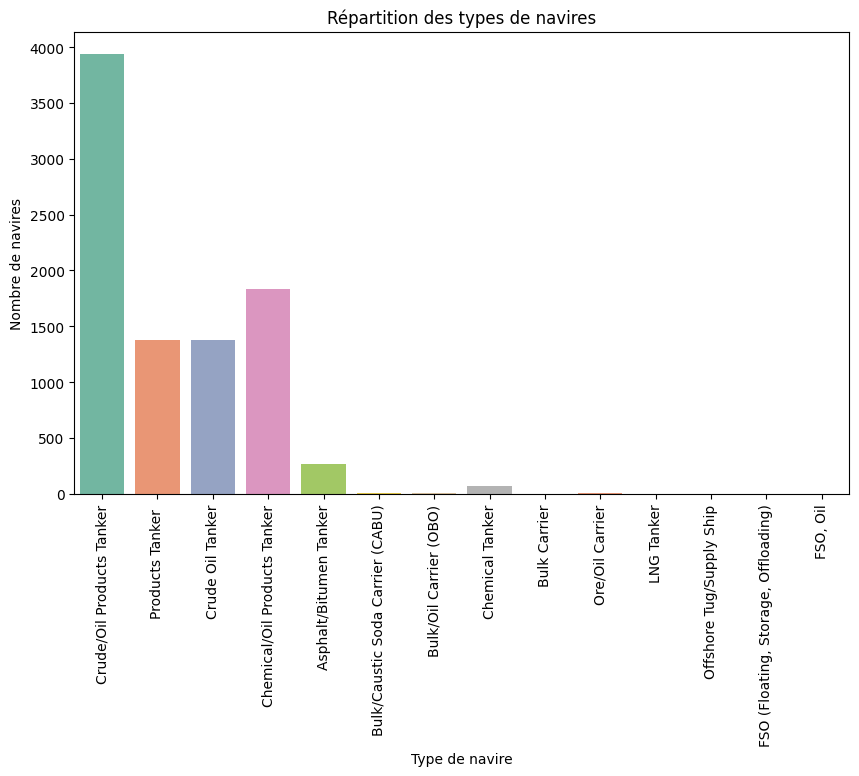

<ipython-input-143-e59285ca49f5>:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=vessels, x='vessel_type', y='dead_weight', palette='Set3')


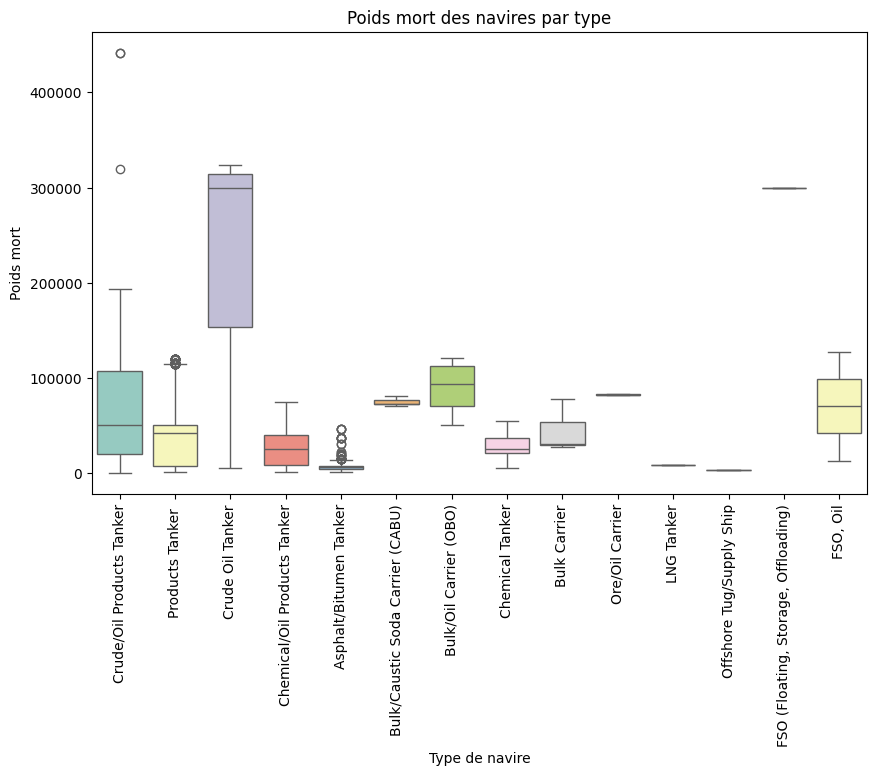

In [143]:
# Charger les données
port_calls = pd.read_csv("/content/port_calls.csv")
trades = pd.read_csv("/content/trades.csv")
vessels = pd.read_csv("/content/vessels.csv")
final = pd.read_csv("/content/final.csv")

# --- Section 1: Visualisation des trajets par destination ---
# Tracer le nombre de trajets par destination
plt.figure(figsize=(10, 5))
destination_counts = final['port_name_destination'].value_counts().head(50)
sns.barplot(x=destination_counts.index, y=destination_counts.values, palette="viridis")
plt.xticks(rotation=90)
plt.xlabel("Port de destination")
plt.ylabel("Nombre de trajets")
plt.title("Fréquence des destinations")
plt.show()

# --- Section 2: Visualisation des trajets par produit ---
# Tracer le nombre de trajets par produit
plt.figure(figsize=(10, 5))
product_counts = final['product_family'].value_counts()
sns.barplot(x=product_counts.index, y=product_counts.values, palette="magma")
plt.xticks(rotation=90)
plt.xlabel("Produit")
plt.ylabel("Nombre de trajets")
plt.title("Fréquence des produits transportés")
plt.show()

# --- Section 3: Histogramme de la durée de trajet ---
# Tracer l'histogramme de la durée de trajet
plt.figure(figsize=(10, 5))
sns.histplot(final['duration_target(h)'], bins=30, kde=True, color="royalblue")
plt.xlabel("Durée de trajet (h)")
plt.ylabel("Fréquence")
plt.title("Distribution de la durée de trajet")
plt.show()

# --- Section 4: Scatter plot entre cargo_volume et draught_change ---
# Créer un scatter plot entre cargo_volume et draught_change
plt.figure(figsize=(10, 5))
sns.scatterplot(data=final, x='cargo_volume', y='draught_change', alpha=0.4, color='royalblue')
plt.xlabel('cargo_volume')
plt.ylabel('draught_change')
plt.title('Relation entre cargo_volume et draught_change')
plt.show()

# --- Section 5: Relation entre la distance et le volume échangé ---
# Tracer la relation entre la distance et le volume échangé
plt.figure(figsize=(10,5))
sns.scatterplot(data=trades, x="distance", y="traded_volume", alpha=0.5)
plt.xlabel("Distance (km)")
plt.ylabel("Volume échangé (tonnes)")
plt.title("Relation entre distance et volume échangé")
plt.show()

# --- Section 6: Visualisation des types de navires par destination ---
# Fusion des données pour obtenir les types de navires associés aux routes
merged = port_calls.merge(vessels, left_on="vessel_id", right_on="id")

# Tracer les types de navires par destination
plt.figure(figsize=(12,6))
route_types = merged.groupby(["destination", "vessel_type"]).size().reset_index(name="count")
sns.barplot(data=route_types.sort_values(by="count", ascending=False).head(20),
            x="count", y="destination", hue="vessel_type", palette="Set2")
plt.xlabel("Nombre de passages")
plt.ylabel("Port de destination")
plt.title("Types de navires sur les routes principales")
plt.show()

# --- Section 7: Visualisations sur les navires ---

# 1. Histogramme des années de construction des navires
plt.figure(figsize=(10, 6))
sns.histplot(vessels['build_year'], bins=30, kde=True, color='blue')
plt.title('Distribution des années de construction')
plt.xlabel('Année de construction')
plt.ylabel('Nombre de navires')
plt.show()

# 2. Répartition des types de navires
plt.figure(figsize=(10, 6))
sns.countplot(data=vessels, x='vessel_type', palette='Set2')
plt.title('Répartition des types de navires')
plt.xlabel('Type de navire')
plt.ylabel('Nombre de navires')
plt.xticks(rotation=90)
plt.show()

# 3. Poids mort des navires par type de navire
plt.figure(figsize=(10, 6))
sns.boxplot(data=vessels, x='vessel_type', y='dead_weight', palette='Set3')
plt.title('Poids mort des navires par type')
plt.xlabel('Type de navire')
plt.ylabel('Poids mort')
plt.xticks(rotation=90)
plt.show()



#### Correlation Matrix:

This code helps analyze the relationship between the numerical variables in our dataset. We first removed the non-numeric columns, keeping only those that could be used in a correlation analysis. Then, we calculated the correlation matrix, which measures the strength and direction of the linear relationships between the numerical variables. This matrix is then visualized using a heatmap, where the correlation values are displayed for each pair of variables. The generated graph helps us quickly identify the strongest relationships and those that are less significant between the variables.


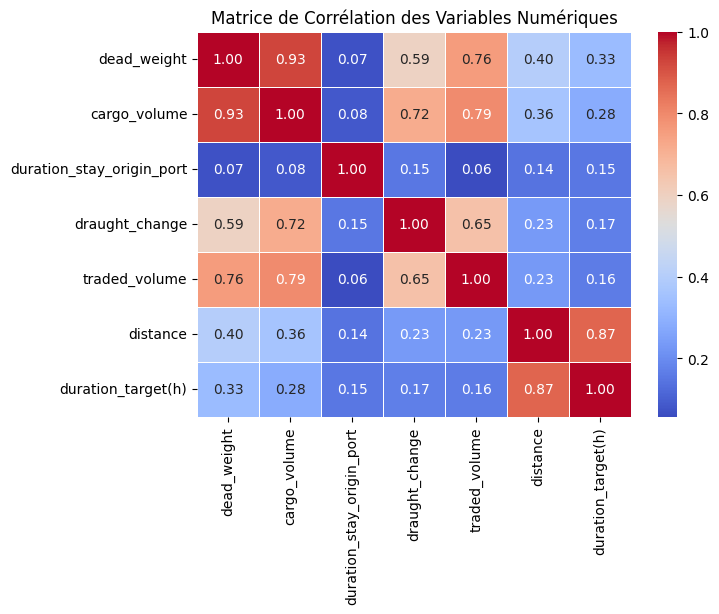

In [149]:
# Supprimer les colonnes non numériques
final_numeric = final.drop(columns=['trades_id', 'port_name_origin', 'port_name_destination', 'vessel_id','product','vessel_type','product_family'])

# Calculer la matrice de corrélation
corr_matrix = final_numeric.corr()

# Tracer la matrice de corrélation
plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Ajouter un titre
plt.title('Matrice de Corrélation des Variables Numériques')

# Afficher le graphique
plt.show()


## Building a Vessel Database with a Sequence of Ports of Call

The goal of **building a database of vessels with a sequence of their ports of call** is to achieve several important objectives for us.

1. **Understanding Vessel Routes**: By having the sequence of visited ports, we can get an overview of the paths followed by each vessel. This allows us to analyze traffic patterns, identify popular and underutilized routes, and better understand the global movement of vessels.

2. **Route Optimization**: Knowing the port sequences helps us analyze and optimize vessel routes in terms of both **time** and **cost**. This enables us to target the most efficient routes and maximize the performance of voyages.

3. **Forecasting and Planning**: By identifying the most frequently visited ports, we can anticipate future journeys and better plan resource needs, such as managing port capacities.

4. **Vessel Monitoring**: By combining information about vessels, their type, dead weight, cargo volume, and the ports they visit, we can track vessel performance and assess their efficiency and impact.

5. **Improving Data Analytics**: Sequencing the ports allows us to analyze temporal and geographical relationships. This helps us extract insights on routes, which is crucial for logistics management and strategic planning in maritime operations.

In summary, the **port sequence** helps us improve maritime route management, optimize routes, and better plan operations within the maritime sector.

In [150]:
# Trier les ports par ordre chronologique (start_utc) pour chaque vessel_id
port_calls_sorted = port_calls.sort_values(by=['vessel_id', 'start_utc'])

# Récupérer la destination (dernier port visité)
last_destinations = port_calls_sorted.groupby('vessel_id')['destination'].last().reset_index()
last_destinations.rename(columns={'destination': 'destination'}, inplace=True)

# Grouper les ports visités sous forme de séquence (sans la destination)
port_sequences = port_calls_sorted.groupby('vessel_id')['destination'].apply(lambda x: ' -> '.join(x[:-1])).reset_index()
port_sequences.rename(columns={'destination': 'sequence_port_names'}, inplace=True)

# Sélectionner les infos des navires depuis la base 'final'
vessel_info = final[['vessel_id', 'vessel_type', 'dead_weight', 'cargo_volume']].drop_duplicates()

# Fusionner les données pour obtenir la base finale
vessel_routes_db = pd.merge(vessel_info, port_sequences, on='vessel_id', how='inner')
vessel_routes_db = pd.merge(vessel_routes_db, last_destinations, on='vessel_id', how='inner')
vessel_routes_db.to_csv("vessel_routes_db.csv", index=False)
vessel_routes_db

,vessel_id,vessel_type,dead_weight,cargo_volume,sequence_port_names,destination
0,115306.0,Chemical/Oil Products Tanker,8714.0,4981.0,Singapore -> Pasir Gudang -> Kuantan -> Kerteh...,Singapore
1,115306.0,Chemical/Oil Products Tanker,8714.0,6639.0,Singapore -> Pasir Gudang -> Kuantan -> Kerteh...,Singapore
2,115306.0,Chemical/Oil Products Tanker,8714.0,11404.0,Singapore -> Pasir Gudang -> Kuantan -> Kerteh...,Singapore
3,74310.0,Crude/Oil Products Tanker,12083.0,12995.0,Thung Khru -> Samut Prakan -> Singapore -> Sin...,Rayong
4,82159.0,Crude/Oil Products Tanker,109290.0,114701.0,Schiehallion -> Frederikshavn Light. -> Catche...,Rotterdam
...,...,...,...,...,...,...
60359,102681.0,Crude/Oil Products Tanker,49999.0,49150.0,Sao Sebastiao -> Rio de Janeiro -> Paranagua -...,Coatzacoalcos
60360,102681.0,Crude/Oil Products Tanker,49999.0,41406.0,Sao Sebastiao -> Rio de Janeiro -> Paranagua -...,Coatzacoalcos
60361,102681.0,Crude/Oil Products Tanker,49999.0,42927.0,Sao Sebastiao -> Rio de Janeiro -> Paranagua -...,Coatzacoalcos
60362,102681.0,Crude/Oil Products Tanker,49999.0,34748.0,Sao Sebastiao -> Rio de Janeiro -> Paranagua -...,Coatzacoalcos



We have **1186** different classes in the **destination** column, but many of them are rare. To avoid imbalance issues, we group these infrequent destinations under the "Other" category using a threshold of 15 occurrences. This reduces the number of classes to **705**, helping to balance the data. After grouping, the number of remaining classes is reduced to **705**.

Next, for the port sequences, we extracted about **500** unique ports and encoded the sequences of the **last 30** visited ports. This allows us to retain the most recent information while reducing the **complexity** of the sequences.

In [161]:
# Charger la base de données
df = pd.read_csv('vessel_routes_db.csv')  # Remplace par ton fichier

# Supprimer les lignes avec des valeurs manquantes dans 'destination' ou 'sequence_port_names'
df = df.dropna(subset=['destination', 'sequence_port_names'])

# --------------------------
# 1. Regroupement des destinations rares
# --------------------------
# Compter les occurrences de chaque destination
destination_counts = df['destination'].value_counts()

# Seuil pour garder une classe individuelle (ex: au moins 15 occurrences)
threshold = 15

# Remplacer les destinations rares par 'Other'
df['destination'] = df['destination'].apply(lambda x: x if destination_counts[x] >= threshold else 'Other')

# Encodage des destinations
label_encoder = LabelEncoder()
df['destination_encoded'] = label_encoder.fit_transform(df['destination'])

# Vérifier le nombre de classes après regroupement
print(f"Nombre de classes après regroupement: {len(label_encoder.classes_)}")

# --------------------------
# 2. Encodage des séquences de ports
# --------------------------
# Extraction des ports uniques pour créer un dictionnaire de tokens
unique_ports = set()
for sequence in df['sequence_port_names']:
    unique_ports.update(sequence.split(' -> '))

# Créer un dictionnaire d'encodage des ports
port_to_token = {port: idx for idx, port in enumerate(unique_ports)}

# Fonction pour encoder une séquence de ports en gardant les 30 derniers
def encode_sequence(seq):
    ports = seq.split(' -> ')
    ports = ports[-30:]  # Garder uniquement les 30 derniers ports
    return [port_to_token.get(port, -1) for port in ports]  # -1 si le port n'est pas trouvé

# Appliquer l'encodage des séquences de ports
df['sequence_encoded'] = df['sequence_port_names'].apply(encode_sequence)

# Vérification finale
print(f"Taille du dictionnaire de ports: {len(port_to_token)}")
df.head()


Nombre de classes après regroupement: 705
Taille du dictionnaire de ports: 2024


,vessel_id,vessel_type,dead_weight,cargo_volume,sequence_port_names,destination,destination_encoded,sequence_encoded
0,115306.0,Chemical/Oil Products Tanker,8714.0,4981.0,Singapore -> Pasir Gudang -> Kuantan -> Kerteh...,Singapore,574,"[1591, 1312, 752, 1793, 1811, 1793, 1593, 1593..."
1,115306.0,Chemical/Oil Products Tanker,8714.0,6639.0,Singapore -> Pasir Gudang -> Kuantan -> Kerteh...,Singapore,574,"[1591, 1312, 752, 1793, 1811, 1793, 1593, 1593..."
2,115306.0,Chemical/Oil Products Tanker,8714.0,11404.0,Singapore -> Pasir Gudang -> Kuantan -> Kerteh...,Singapore,574,"[1591, 1312, 752, 1793, 1811, 1793, 1593, 1593..."
3,74310.0,Crude/Oil Products Tanker,12083.0,12995.0,Thung Khru -> Samut Prakan -> Singapore -> Sin...,Rayong,519,"[1593, 1451, 582, 582, 1284, 38, 1745, 582, 15..."
4,82159.0,Crude/Oil Products Tanker,109290.0,114701.0,Schiehallion -> Frederikshavn Light. -> Catche...,Rotterdam,530,"[779, 1054, 912, 1457, 2005, 1140, 1140, 1140,..."


Here’s the translation in English:

---

## Deep Learning Model Design

We developed a **Deep Learning** model to predict a ship's **destination** based on its past routes, **type**, and certain characteristics such as its **deadweight** and **cargo volume**.

### 1. Data Preparation
We prepared the data by applying **padding** to the port sequences with a fixed length of **30**. Next, we encoded the **destinations** into **705 classes**, grouping rare classes into the "**Other**" category. Numerical variables like **deadweight** and **cargo volume** were normalized using **MinMaxScaler**.

### 2. Model Construction
The model is based on a **GRU** (Gated Recurrent Unit) architecture suited for sequential data. We used an **embedding** layer with **64 dimensions** to transform the port sequences. A **GRU** layer with **32 units** and dense layers with **Dropout** were added to prevent overfitting. The model outputs **705 classes**, corresponding to the different possible destinations.

### 3. Training and Evaluation
The model was trained for **100 epochs** with a **batch size** of **64** and validated on a test set representing **20%** of the data. After training, the model achieved a **test accuracy** of **X%** (accuracy to be inserted after actual evaluation).

In summary, this model effectively predicts the **destination** of ships by analyzing their past port sequences, considering information such as the ship's type and its physical characteristics.

In [164]:
# -------------------------------
# 1. Préparation des données
# -------------------------------
max_length = 30  # Augmentation de la séquence à 30

# Récupérer les séquences et appliquer le padding pour obtenir une longueur fixe
X_ports = df['sequence_encoded'].tolist()
X_padded = pad_sequences(X_ports, maxlen=max_length, padding='pre', truncating='pre')

# Encodage des labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['destination'])

# Encodage du type de navire
vessel_encoder = LabelEncoder()
X_vessel_type = vessel_encoder.fit_transform(df['vessel_type'])

# Normalisation des variables numériques
scaler = MinMaxScaler()
X_dead_weight = scaler.fit_transform(df[['dead_weight']])
X_cargo_volume = scaler.fit_transform(df[['cargo_volume']])

# Combinaison des variables
X_combined = np.column_stack([X_padded, X_vessel_type, X_dead_weight.flatten(), X_cargo_volume.flatten()])

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Affichage des informations sur les données
print(f"\nShape de X_train: {X_train.shape}")
print(f"\nShape de X_test: {X_test.shape}")
print(f"\nShape de y_train: {y_train.shape}")
print(f"\nShape de y_test: {y_test.shape}")
print(f"Nombre de classes: {len(label_encoder.classes_)}")

# Taille du vocabulaire
vocab_size = len(port_to_token)
# -------------------------------
# 2. Construction du modèle Deep Learning (GRU)
# -------------------------------
embedding_dim = 64
gru_units = 32
dense_units = 32

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    GRU(gru_units),
    Dropout(0.3),
    Dense(dense_units, activation='relu'),
    Dropout(0.3),
    Dense(len(label_encoder.classes_), activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Affichage du résumé du modèle
print("\nRésumé du modèle:")
model.build(input_shape=(None, max_length))
model.summary()

# -------------------------------
# 3. Entraînement du modèle
# -------------------------------
print("\nDébut de l'entraînement du modèle...")
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_test, y_test)
)
# -------------------------------
# 4. Évaluation sur l'ensemble de test
# -------------------------------
loss, accuracy = model.evaluate(X_test, y_test)
print("\nTest Accuracy: {:.2f}%".format(accuracy * 100))



Shape de X_train: (48291, 33)

Shape de X_test: (12073, 33)

Shape de y_train: (48291,)

Shape de y_test: (12073,)
Nombre de classes: 705

Résumé du modèle:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)             │ (None, 30, 64)              │         129,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_7 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 705)                 │          23,265 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 163,265 (637.75 KB)

 Trainable params: 163,265 (637.75 KB)

 Non-trainable params: 0 (0.00 B)


Début de l'entraînement du modèle...
Epoch 1/100
755/755 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - accuracy: 0.0561 - loss: 5.9734 - val_accuracy: 0.0653 - val_loss: 5.5508
Epoch 2/100
755/755 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.0798 - loss: 5.3738 - val_accuracy: 0.1059 - val_loss: 4.8128
Epoch 3/100
755/755 ━━━━━━━━━━━━━━━━━━━━ 43s 31ms/step - accuracy: 0.1031 - loss: 4.7847 - val_accuracy: 0.1287 - val_loss: 4.3977
Epoch 4/100
755/755 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - accuracy: 0.1208 - loss: 4.4463 - val_accuracy: 0.1496 - val_loss: 4.0760
Epoch 5/100
755/755 ━━━━━━━━━━━━━━━━━━━━ 38s 26ms/step - accuracy: 0.1404 - loss: 4.1522 - val_accuracy: 0.1722 - val_loss: 3.7954
Epoch 6/100
755/755 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.1536 - loss: 3.9298 - val_accuracy: 0.1978 - val_loss: 3.5713
Epoch 7/100
755/755 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.1789 - loss: 3.7215 - val_accuracy: 0.2267 - val_loss: 3.3634
Epoch 8/100
755/755 ━━━━━━━━━━━━━━━━━━━━ 46s 

To improve the model, I would suggest starting with the following:

1. **Incorporate Additional Features**: Consider adding features like weather conditions, vessel speed, or other external factors that might impact port visits. These can provide more context and potentially improve the model's performance.

2. **Experiment with Different Architectures**: You can explore different architectures such as Random Forest, Gradient Boosting, or neural network variants like LSTM if your data has a temporal component. If using a neural network, trying more complex architectures like a deeper network might capture more complex patterns.

3. **Increase Dataset Size**: If possible, adding more data from different periods or geographic regions could help the model generalize better. More data usually helps improve performance, especially when working with machine learning models that rely on large amounts of data to learn effectively.

4. **Hyperparameter Tuning**: Conduct a more extensive search for optimal hyperparameters (e.g., learning rate, number of layers, or batch size). Using techniques like Grid Search or Random Search could help identify the best parameters for your model.

5. **Regularization and Dropout**: Implementing regularization techniques such as L2 regularization or adding dropout layers can prevent overfitting, which would be particularly useful since your model already has a higher validation accuracy compared to the training accuracy.

Trying these methods in combination would be the best approach. Start with small experiments to see which changes have the most significant impact on your model's performance.

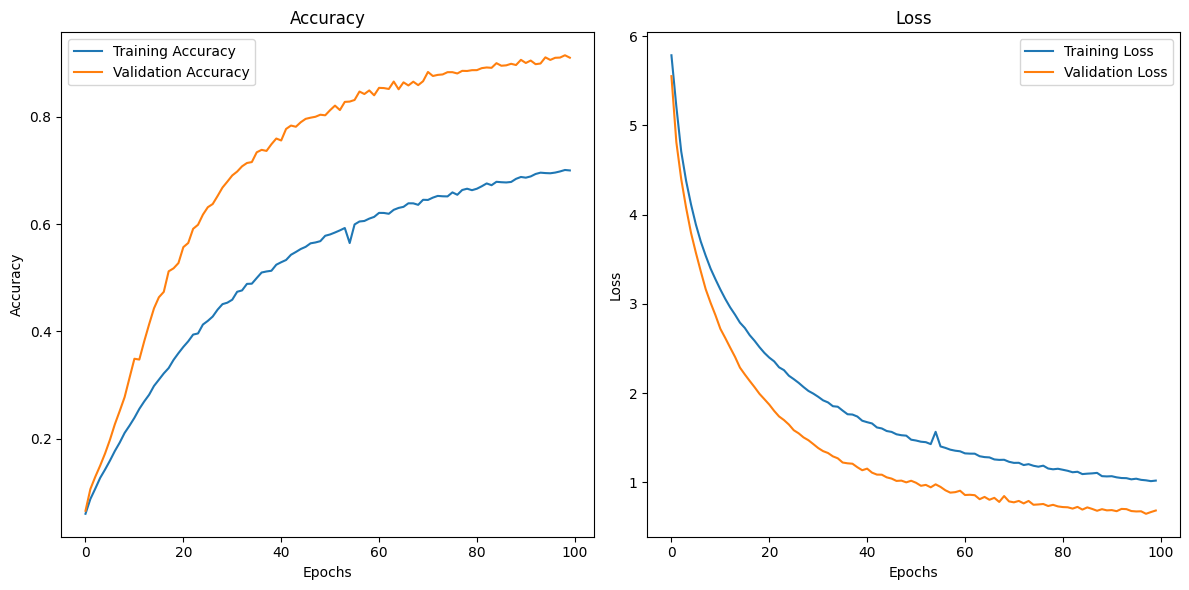

In [165]:
# Visualisation de l'accuracy
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()